# Testing the number of bumps that best explains the data

We usually do not have precise enough information to decide a priori on a number of bumps that an HsM model should have. To illustrate the problem let's use the data generated in the documenation on how to read data:

In [1]:
import xarray as xr
import numpy as np

unstacked_data = xr.load_dataset('unstacked_data.nc')
positions = np.load('positions.npy')

One way to decide on a given number is to look at what number of bumps best fits the data (hence the number of bumps with the highest likelihood) by fitting all possible number of bumps from 1 bump to *n* bumps where *n* is given by how many *x* milliseconds bumps fit into a mean reaction time of *y* milliseconds (e.g. a minimum reaction time of 400 ms with 50ms bumps allow for the estimation of up to 8 bumps). The function ```backward_estimation``` allows to do this automatically by first estimating *n* bump model up to 1 bump model.

In [2]:
import hsmm_mvpy as hsmm
import os 

stacked_data = hsmm.utils.stack_data(unstacked_data.data, 'participant')
init = hsmm.models.hsmm(stacked_data.data.T, stacked_data.starts, stacked_data.ends, sf=100, bump_width=50, cpus=4)

bests = init.backward_estimation(max_starting_points=200)#We add a lot of starting points to be sure that the estimation procedure of the max bump models doesn't end up in a local minima

bests

<xarray.Dataset>
Dimensions:      (n_bumps: 8, stage: 9, params: 2, component: 10, bump: 8,
                  samples: 300, trial: 14496)
Coordinates:
  * n_bumps      (n_bumps) int64 8 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 ...
    parameters   (n_bumps, stage, params) float64 ...
    magnitudes   (n_bumps, component, bump) float64 ...
    eventprobs   (n_bumps, samples, trial, bump) float64 ...

But adding more and more parameters will almost always improve the fit amd we might end up adding bumps either to noise or to idiosyncratic data that will not generalize. 

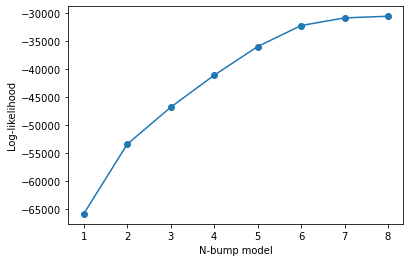

In [3]:
import matplotlib.pyplot as plt 

plt.plot(np.arange(init.max_bumps)+1, bests.likelihoods[::-1],'o-')
plt.ylabel('Log-likelihood')
plt.xlabel('N-bump model')
plt.show()

Hence we need a way to penalize the likelihood if the bumps location do not generalize to all participants. One way to do this is to perform a leave-one out cross-validation. This approach consists in fitting the model to all participants but one, and evaluate the likelihood of the left out participant given the estimated parameters without the participant. The function ```hsmm.utils.LOOCV``` does this and we can apply it to all participants and all *n* bump model.

In [7]:
participants = unstacked_data.participant.data
max_bumps = init.max_bumps #max bump is already calculated when init is created

all_loo = np.empty((len(participants), max_bumps))
for n_bumps in np.arange(1,max_bumps+1):#  from 1 to the maximum possible number of bumps 
    for participant in participants:
        all_loo[participant, :n_bumps], _ = hsmm.utils.LOOCV(unstacked_data.data, participant, n_bumps, bests.sel(n_bumps=n_bumps), 100)


KeyboardInterrupt



Note that the LOOCV can be slow when there are a lot of participants, in this case it might be worse to add multiprocessing although the code becomes less lisible:

In [5]:
import multiprocessing
import itertools

participants = unstacked_data.participant.data

likelihoods_loo = []
cpus = 4#how many processes should be used, increasing this number also increases RAM usage
all_n_bumps = []
for n_bumps in np.arange(1,init.max_bumps+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.utils.LOOCV, 
            zip(itertools.repeat(unstacked_data), participants, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(100)))
    all_n_bumps.append(loo)

loocv = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                       "participants":np.array(all_n_bumps)[0,:,1]})
loocv

<xarray.Dataset>
Dimensions:       (n_bump: 8, participants: 20)
Coordinates:
  * n_bump        (n_bump) int64 1 2 3 4 5 6 7 8
  * participants  (participants) float64 0.0 1.0 2.0 3.0 ... 16.0 17.0 18.0 19.0
Data variables:
    data          (n_bump, participants) float64 ...

We can then plot the result from the LOOCV procedure

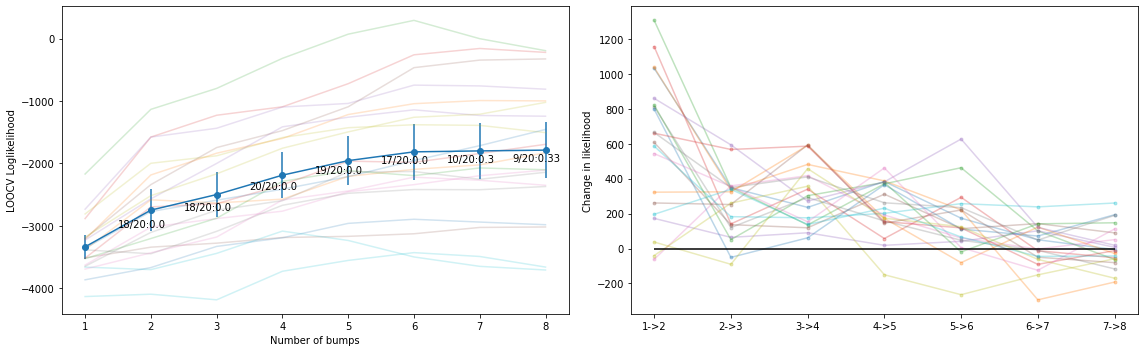

In [6]:
hsmm.visu.plot_LOOCV(loocv.data, pvals=True, test='t-test', indiv=True)

Based on the numer of participant that improved (17/20) and the p-value from a one-sided t-test (<.01), the model with 6 bumps appears to be the prefered model after the LOOCV procedure 